In [12]:
#consider using svist4get api for adding open chromatin peak tracks: https://bitbucket.org/artegorov/svist4get/src/eeb5151f49c31fa887dbfc168320c63d66a17334/docs/API.md
#actually use https://github.com/deeptools/pyGenomeTracks as can install with conda
#then import each track as vector image like here: https://stackoverflow.com/questions/31452451/importing-an-svg-file-into-a-matplotlib-figure using svgutils
#integrate it with matplotlib like mentioned here: https://github.com/deeptools/pyGenomeTracks/issues/20
#the bigwig files I used were from potter et al 2018 NaOH treatment https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE116287 called GSE116287_Roots_NaOH_Merged.bw and GSE116287_Shoots_NaOH_Merged.bw
#had to install "conda install -c conda-forge tqdm" too

##NOTE - if using genbank files from Benchling, first add custom fields on the metadata page with the start and end index (eg. start_index 6015558)
##also ensure the name of the genebank file (and sequence id) include the AGI locus name enclosed in parentheses(eg. "(AT4G24020)")
##This is so the chromosome number can be extracted
##This is to ensure the start and end chromosome positions open chromatin data
#make sure when exporting the .gb file from Benchling that you do not tick "Convert Non-Standard Annotation Types"
#I merged bigwig files with DNaseseq data from Sullivan et al 2014 using WiggleTools (not shown in this notebook)
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib import rcParams
from matplotlib.gridspec import GridSpec
import matplotlib.text as mtext

#latex style rendering so can make parts of text bold
from matplotlib import rc
#import matplotlib as mpl
from Bio import SeqIO

from Bio.SeqRecord import SeqRecord
from Bio.SeqFeature import SeqFeature, FeatureLocation, ExactPosition, BeforePosition, AfterPosition, BetweenPosition, WithinPosition, CompoundLocation


import numpy as np
#allows custom colours
from dna_features_viewer import BiopythonTranslator
import pandas as pd
from itertools import cycle
import re
import pandas as pd
#allow converting from RGB to CMYK
#import cv2
from PIL import Image
# from PIL import Image
# from io import BytesIO
import pygenometracks.tracks as pygtk

###note  - use conda env gene_feature_plot


In [13]:
#create a class specifying feature colours
#make feature_list and colour_dict so that each feature name and colour is only added once to legend if more than one share the same name
feature_list = []
colour_dict = {}
#set probel_labels on or off here
probe_labels = False
#turn on or off open chromatin peak annotations
open_chromatin = False
#set font size
font_size = 9
class MyCustomTranslator(BiopythonTranslator):
    """Custom translator iplementing the following theme:
    -Colour promoter in pale green
    -colour exons in dark grey
    -colour introns in light grey
    -colour TFs from colour palette"""

    #import colour blind palette
    #colour palette from mkweb.bcgsc.ca/colorblind/palettes.mhtml
    # df = pd.read_csv("colourblind_palette.csv", header=0)
    # #convert to floats
    # floats=df.divide(255)
    # #make sets of each row to get the red, green blue colours
    # CB_colour_palette = floats.apply(tuple, axis = 1)
    # #make into df
    # df = CB_colour_palette.to_frame()
    # #save file
    # df.to_csv('../../data/TRAMP/colour_list')
    
    # #turn into a list of colour sets
    # list_colours = list(CB_colour_palette)
    # colour_list = list_colours
    #colour_list = ['#88CCEE', '#44AA99', '#117733', '#332288', '#DDCC77', '#999933','#CC6677', '#882255', '#AA4499', '#DDDDDD']
    colour_list = [
    '#e69f00',#DREB26    
    '#2271B2',#ARF9/18
    '#3DB7E9',#ANR1
    '#F748A5',#TGA1      
    '#d55e00',#ANAC032
    '#228833',#NLP6/7
    
    #'#f0e442',
    
    '#900000',]
    #make colour iterator
    colour_iterator=cycle(colour_list)
    #change colour cycle
    #mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=list_colours)
    #count = -1
    #set colour count


    def compute_feature_color(self, feature):
        """set colour of each feature"""      

        if feature.type == "promoter":
            return "#F5F5F5"
        elif feature.type == "gene_upstream":
            return "#DDCC77"#2f4f4f"#dark slate grey
        elif feature.type == "mRNA_upstream":
            return "#DDCC77"#dark slate grey
        elif feature.type == "exon_upstream":
            return "#DDCC77"#dark slate grey
        elif feature.type == "exon":
            return "#635147"#umber
        elif feature.type == "gene":
            return "#F5F5F5"
            #return (169,169,169)
        elif feature.type == "intron":
            return "lightgrey"  
            #return (211,211,211)
        elif feature.type == "5'UTR":
            return "c4aead"#silver pink
        elif feature.type == "start_codon":
            return "black"
        elif feature.type == "TRAMP_probe_tested":
            pass
        #     if feature.qualifiers.get("label")[0] == "NLP7#7":
        #         col = "#e69f00"
        #     elif feature.qualifiers.get("label")[0] == "NLP7#9":
        #         col = "#d55e00"
        #     elif feature.qualifiers.get("label")[0] == "NLP7#10":
        #         col = "#2271B2"
        #     elif feature.qualifiers.get("label")[0] == "ANAC032#4":
        #         col = "#2271B2"
        #     elif feature.qualifiers.get("label")[0] == "ANAC032#8":
        #         col = "#F748A5"
        #     elif feature.qualifiers.get("label")[0] == "ANAC032#3":
        #         col = "#000000"

        #     else:        
        #         pass
                        
        #     return col
        
        elif feature.type=="root_open_chromatin":
            if open_chromatin is True:
                #transparency 25%
                return "#a52a2a40"

            else:
                pass
            
        elif feature.type=="shoot_open_chromatin":
            if open_chromatin is True:
                #transparency 25%
                return "#00808040"
            else:
                pass
            
        elif feature.type == "TFBS":
            if feature.qualifiers.get("label")[0] in colour_dict.keys():
                col = colour_dict[feature.qualifiers.get("label")[0]]
            else:
                col = next(self.colour_iterator)
                colour_dict[feature.qualifiers.get("label")[0]] = col
                        
            return col
        else:
            return "black"



    def compute_feature_box_linewidth(self, feature):
        """change feature box linewidth"""
        if feature.type == 'start_codon':
            return 1
        if feature.type =="TRAMP_probe_tested":
            if probe_labels is True:
                print(f'probe labels = True')
                #if prob labels = True, add probe labels
                return 1       
        else:
            return 0
    
    def compute_feature_thickness(self, feature):
        """change feature vertical thickness"""
        if open_chromatin is True:
            if feature.type == "root_open_chromatin":
                return 700
            if feature.type == "shoot_open_chromatin":
                return 0.1
        else:
            return 14

    def compute_feature_linewidth(self, feature):
        """change linewidth of feature's arrow/rectangle"""
        #remove border from certain features
        if feature.type == "gene_upstream":
            return 0
        if feature.type == "start_codon":
            return 1
        elif feature.type == "mRNA_upstream":
            return 0
        elif feature.type == "exon_upstream":
            return 0
        elif feature.type == "misc_RNA_upstream":
            return 0  
        elif feature.type == "exon":
            return 0
        elif feature.type == "intron":
            return 0
        elif feature.type == "5'UTR":
            return 0
        elif feature.type == "TFBS":
            return 0
        elif feature.type =="TRAMP_probe_tested":
            if probe_labels is True:
                #if prob labels = True, add probe labels
                return 1
            elif probe_labels is False:
                return 0
        #open chromatin features
        if open_chromatin is True:
            if feature.type == "root_open_chromatin":
                return 0
            if feature.type == "shoot_open_chromatin":
                return 0
        return 0
    #this doesn't seem to work - so I forced it to work when calling this class instead (see make_graphic_record() function within make plot function)
    # def compute_feature_linecolor(self, feature):
    #     if feature.type=="root_open_chromatin":
    #         return "brown"
    #     if feature.type=="shoot_open_chromatin":
    #         return "teal"
        
    #     if feature.type == "TRAMP_probe_tested":
    #         if probe_labels is True:
    #             if feature.qualifiers.get("label")[0] == "NLP7#7":
    #                 col = "#e69f00"
    #             elif feature.qualifiers.get("label")[0] == "NLP7#9":
    #                 col = "#d55e00"
    #             elif feature.qualifiers.get("label")[0] == "NLP7#10":
    #                 col = "#2271B2"
    #             elif feature.qualifiers.get("label")[0] == "ANAC032#4":
    #                 col = "#2271B2"
    #             elif feature.qualifiers.get("label")[0] == "ANAC032#8":
    #                 col = "#F748A5"
    #             elif feature.qualifiers.get("label")[0] == "ANAC032#3":
    #                 col = "#000000"
    #         else:
    #             pass

        # #open chromatin features
        # if open_chromatin is True:
            

        #     else:        
    #     #         pass
    # def compute_linecolor(self, feature):
    #     if feature.type=="root_open_chromatin":
    #         return "brown"
    #     if feature.type=="shoot_open_chromatin":
    #         return "teal"
                           
    
    def compute_feature_box_color(self, feature):
        """change colour of feature box border"""
        if feature.type == "TRAMP_probe_tested":
            if feature.qualifiers.get("label")[0] == "NLP7#7":                
                #col = colour_dict["NLP6/7"]
                col = "#228833"
            elif feature.qualifiers.get("label")[0] == "NLP7#9":
                #col = colour_dict["DREB26"]
                col = "#e69f00"
            elif feature.qualifiers.get("label")[0] == "NLP7#10":
                #col = colour_dict["ANAC032*"]
                col = "#d55e00"
            elif feature.qualifiers.get("label")[0] == "ANAC032#4":
                #col = colour_dict["ANAC032*"]
                col = "#d55e00"
            elif feature.qualifiers.get("label")[0] == "ANAC032#8":
                #col = colour_dict["ARF9/18*"]
                col = "#2271B2"
            elif feature.qualifiers.get("label")[0] == "ANAC032#3":
                #col = colour_dict["TGA1"]
                col = "#F748A5"
            else:        
                return "black"
                        
            return col
        if feature.type=="root_open_chromatin":
            return "brown"
        if feature.type=="shoot_open_chromatin":
            return "teal"
            #'ARF9/18*': '#2271B2', 'ANR1*': '#3DB7E9', 'TGA1': '#F748A5', 'ANAC032*': '#d55e00', 'DREB26': '#e69f00', 'NLP6/7': '#228833'

    def compute_feature_open_left(self, feature):
        """set to true if feature does not end on the left"""
        return False

    def compute_feature_open_right(self, feature):
        """set to true if feature does not end on the right"""
        return False

    def compute_feature_label(self, feature):
        """Remove most feature labels"""
        if feature.type == 'start_codon':
            return "ATG"
        if feature.type == 'TRAMP_probe_tested':
            if probe_labels is True:
                return feature.qualifiers.get("label")[0]     
        else:
            pass
    

        #return super().compute_feature_label(feature)
    # def compute_feature_min_y_height_of_text_line(self, feature):
    #     return 0.1

    def compute_feature_fontdict(self, feature):
        """change label font to arial, size to 9"""
        if feature.type == "TRAMP_probe_tested":
            #if certain label, align to the right
            if feature.qualifiers.get("label")[0] == "ANAC032#3":            
                return dict(family='sans-serif',size=font_size, ha='right')
            # elif feature.qualifiers.get("label")[0] == "ANAC032#8":
            #     return dict(family='sans-serif',size=10, ha='left')
            if feature.qualifiers.get("label")[0] == "ANAC032#8":            
                return dict(family='sans-serif',size=font_size)
            else:
                return dict(family='sans-serif',size=font_size)

        else:
            return dict(family='sans-serif',size=font_size)
        #return dict([('family','sans-serif'),('sans-serif','Arial'),('size',10)])

    #make feature_list so that each feature name is only added once if more than one share the same name
    #feature_list = []
    def compute_feature_legend_text(self, feature):
        """add legend if feature label has not been added to legend already"""
        if feature.type=='promoter':
            pass
        # elif feature.type=='exon':
        #     pass
        # elif feature.type=='intron':
        #     pass
        # elif feature.type=="5'UTR":
        #     pass
        # elif feature.qualifiers.get("label")[0] in self.feature_list:
        #     pass
        elif feature.qualifiers.get("label")[0] in feature_list:
            pass
        else:
            
            feature_list.append(feature.qualifiers.get("label")[0])
                 
            #feature_list.append(feature.qualifiers.get("label")[0])
            return feature.qualifiers.get("label")[0]     


    def compute_filtered_features(self, features):
        """Displays feature if feature is not one of the following"""
        if probe_labels is True:
            return [
            feature for feature in features
            if (feature.type != "TRAMP_probe")            
            and (feature.type != "none")
            and (feature.type != "DHS")
            and (feature.type != "misc_feature")
            and (feature.type != "primer")
            #and (feature.type != "gene")
            and (feature.type != "mRNA")
            and (feature.type != "CDS")
            and (feature.type != "source")
            and (feature.type != "misc_RNA")
            and (feature.type != "EMSA_probe_long")
            and (feature.qualifiers.get("label")[0] != "ARID5_ARID6"
            and (feature.qualifiers.get("label")[0] != "ARDI5_ARID6")
            and ('Translation' not in feature.qualifiers.get("label")[0])
            #return feature only if it is one of the following:

            and ((feature.type == "TFBS")
            #or (feature.type == "root_open_chromatin")
            #or (feature.type == "shoot_open_chromatin")
            or (feature.type == "promoter")
            or (feature.type == "exon") 
            or (feature.type == "intron") 
            or (feature.type == "start_codon") 
            #or (feature.type == "gene")
            or (feature.type == "exon_upstream")
            or (feature.type == "mRNA_upstream")
            or (feature.type == "gene_upstream")
            or (feature.type == "misc_RNA_upstream")
            or (feature.type == "5'UTR")
            or (feature.type == "TRAMP_probe_tested")
            ))
            ]

        else:
            return [
                feature for feature in features
                if (feature.type != "TRAMP_probe")
                and (feature.type != "TRAMP_probe_tested")        
                and (feature.type != "none")
                and (feature.type != "DHS")
                and (feature.type != "misc_feature")
                and (feature.type != "primer")
                #and (feature.type != "gene")
                and (feature.type != "mRNA")
                and (feature.type != "CDS")
                and (feature.type != "source")
                and (feature.type != "misc_RNA")
                and (feature.type != "EMSA_probe_long")
                and (feature.qualifiers.get("label")[0] != "ARID5_ARID6"
                and (feature.qualifiers.get("label")[0] != "ARDI5_ARID6")
                and ('Translation' not in feature.qualifiers.get("label")[0])
                #return feature only if it is one of the following:
                 
                and ((feature.type == "TFBS")
                #or (feature.type == "root_open_chromatin")
                #or (feature.type == "shoot_open_chromatin")
                or (feature.type == "promoter")
                or (feature.type == "exon") 
                or (feature.type == "intron") 
                or (feature.type == "start_codon") 
                #or (feature.type == "gene")
                or (feature.type == "exon_upstream")
                or (feature.type == "mRNA_upstream")
                or (feature.type == "gene_upstream")
                or (feature.type == "misc_RNA_upstream")
                or (feature.type == "5'UTR")
                ))
                ]


In [14]:
#code from https://github.com/biopython/biopython/blob/c733feb84e7c48a54921f2c2ace2c57efdd97c8c/Bio/SeqUtils/SeqSlicerWithFeatures.py
#this allows slicing of a sequence while keeping truncated annotations


# from Bio import SeqIO


def move_position(pos, move: int, keep_all: bool, slice_len: int):
    tt = type(pos)
    if isinstance(pos, (ExactPosition, BeforePosition, AfterPosition)):
        if int(pos) + move < 0:
            return BeforePosition(0)
        elif int(pos) + move > slice_len:
            return AfterPosition(slice_len)
        else:
            return tt(pos + move)
    elif isinstance(pos, (BetweenPosition, WithinPosition)):
        # This would need update if BetweenPosition or WithinPosition gets obsolete or changed
        # attributes accessed because they are not exposed in any other way
        diff_left = pos._left + move
        diff_right = pos._right + move

        if diff_left < 0 and diff_right <= 0:
            return BeforePosition(0)
        elif diff_left < 0 < diff_right:
            if keep_all:
                tt(0, 0, pos._right)
            else:
                return None
        elif diff_left > 0 and diff_right > 0:
            if diff_left < slice_len and diff_right < slice_len:
                return AfterPosition(slice_len)
            elif diff_left < slice_len < diff_right:
                if keep_all:
                    return tt(slice_len, diff_left, slice_len)
                else:
                    return None
            else:
                # This should not be reached
                raise ValueError
        else:
            # This should not be reached
            raise ValueError
    else:
        # raise for not known Position classes
        raise NotImplementedError('slicing for position {} not implemented'.format(type(pos)))


def start_violation_pos(x, sl: slice):
    return x.start.position < sl.start < x.end.position


def end_violation_pos(x, sl: slice):
    return x.start.position < sl.stop < x.end.position


def slice_feature(feature: FeatureLocation, sl: slice, keep_all_features: bool, seq_len: int):
    if isinstance(feature, CompoundLocation):
        of = []
        for ff in feature.parts:
            # this must be without location boundaries checking
            #  - only location objects adjacent to slice boundaries can cross it

            # However we need to check whether the location object is fully inside the slice
            #  (and discard those which are not)

            mps = move_position(ff.start, - sl.start, keep_all_features, seq_len)
            mpe = move_position(ff.end, - sl.start, keep_all_features, seq_len)
            if mps is not None and mpe is not None:
                fl = FeatureLocation(mps, mpe, ff.strand)

            # Feature locations outside of slice gets discarded
            if fl is not None:
                of.append(fl)

        return CompoundLocation(of, operator=feature.operator)
    else:
        if start_violation_pos(feature, sl) or end_violation_pos(feature, sl):

            mps = move_position(feature.start, - sl.start, keep_all_features, seq_len)
            mpe = move_position(feature.end, - sl.start, keep_all_features, seq_len)

            if mps is not None and mpe is not None:

                fl = FeatureLocation(mps, mpe, feature.strand)
                return fl
            else:
                return None
        else:
            return None


def slice_sequence_with_features(seq: SeqRecord, sl: slice, keep_all_features: bool = False) -> SeqRecord:
    """
    This is an attempt to make slicing function for Bio.Seq which retains features which are not fully in slice
      it is intended for visualization purposes where part of a feature also provides valuable information
    # location variants:
    - CompoundLocation - Collection of FeatureLocation objects (for joins etc).             ? -> solved
    - ExactPosition - Specify the position as being exact.                                  OK
    - WithinPosition - Specify a position occurring within some range.                      ? -> solved
    - BetweenPosition - Specify a position occurring between a range (OBSOLETE?).           ? -> solved
    - BeforePosition - Specify the position as being found before some base.                OK
    - AfterPosition - Specify the position as being found after some base.                  OK
    - OneOfPosition - Specify a position where the location can be multiple positions.      ? Not is spec ? -> raise
    - UnknownPosition - Represents missing information like '?' in UniProt.                 raise
    """
    ns = seq[sl.start:sl.stop]

    seq_len = len(ns)
    for feat in seq.features:
        fl = slice_feature(feat.location, sl, keep_all_features, seq_len)
        if fl is not None:
            nf = SeqFeature(
                fl,
                type=feat.type,
                id=feat.id,
                qualifiers=feat.qualifiers,
                ref=feat.ref,
                ref_db=feat.ref_db
            )
            ns.features.append(nf)

    return ns


# if __name__ == '__main__':

#     # to my understanding
#     # the BetweenPosition should be OK (not DEPRECATED)
#     #    - as the between position is only for (n, n+1) - slicing should only retain full feature
#     # the within position (usage restricted)
#     #    - the within position must be inspected
#     # One-of does not exist in specification
#     #    - I do not expect it to see it
#     # Unknown position not considered (maybe do some basic testing that presence would not break the function)

#     # this fails for unknown reason
#     # from Bio import SeqIO
#     # import os
#     # if os.path.exists('../../Tests/GenBank/NC_005816.gb'):
#     #     print('ok')

#     # using example record from Biopython Tests
#     # a = SeqIO.read('../../Tests/GenBank/NC_005816.gb', format='gb')
#     # b = slice_sequence_with_features(a, slice(5933, 5935))
#     # b = slice_sequence_with_features(a, slice(5932, 5934))
#     # b = slice_sequence_with_features(a, slice(5933, 5934))
#     # b = slice_sequence_with_features(a, slice(1370, 1670))
#     # b = slice_sequence_with_features(a, slice(1430, 1460))
#     # b = slice_sequence_with_features(a, slice(1438, 1619))
#     # for f in b.features:
#     #     print(f)

#     print('a')

In [15]:
def preprocess_record(seqrecord,promoter_name, bp_downstream_of_TSS):
    """Preprocess the biopython record before feeding it into the translator."""
    #get length of the whole sequence
    #seq_length = len(seqrecord.seq)
    # #print(f'{seqrecord.id} + {seq_length}')
    # #change seqrecord locations
    # #if start location is greater than TSS position then the new location is the length of the whole sequence minus the original position
    # def convert_location(location, TSS_position, seq_length):
    #     """convert locations to be relative to TSS position (or another locaton if you choose)"""
    #     if location > TSS_position:
    #         new_location = seq_length - location
    #     elif location < TSS_position:
    #         new_location = -(TSS_position-location)
    #     elif location == TSS_position:
    #         new_location = 0
    #     return new_location
    # print(seqrecord)
    #shorten the seqrecord to only a certain length after the TSS
    for feature in seqrecord.features:
        # if feature.type == 'source':
        #     old_start = feature.location.start
        #     old_end = feature.location.end
            
        if feature.type == 'promoter':
            #start at beginning of the promoter, end a certain length after the end of the promoter
            start = feature.location.start
            promoter_end = feature.location.end
            end = promoter_end + bp_downstream_of_TSS
            #print(f'start={start}end={end}')
    #cycle through features, keeping the index information
    #then rename upstream genes that are upstream of the transcription start site (end of promoter)
    def rename_upstream_features(TSS_location,feature_name,seqrecord):
        "function to rename features that are upstream of the transcription start site (end of promoter)"
        for idx, feature in enumerate(seqrecord.features):
            if feature.type == feature_name:
                #if gene is upstream of the TSS, rename feature to gene_upstream
                feature_start=feature.location.start
                feature_end=feature.location.end            
                feature_qualifiers = feature.qualifiers
                if feature_start < TSS_location:
                    #print(f'renaming upstream gene annotation')
                    seqrecord.features[idx]=SeqFeature(FeatureLocation(feature_start,feature_end), type=f"{feature_name}_upstream", qualifiers=feature_qualifiers)  
    #rename upstream features
    rename_upstream_features(promoter_end,'gene',seqrecord)
    rename_upstream_features(promoter_end,'exon',seqrecord)
    #rename_upstream_features(promoter_end,'misc_RNA',seqrecord)
    rename_upstream_features(promoter_end,'mRNA',seqrecord)
    rename_upstream_features(promoter_end,'CDS',seqrecord)
            
    #print(f'start={start}')
    #slice the seqrecord using the new start and end, keeping truncated annotations
    shortened_seqrecord = slice_sequence_with_features(seqrecord, slice(start, end))
    #shortened_seqrecord = seqrecord[start:end]
    #add meta data
    shortened_seqrecord.id = seqrecord.id + "_shortened"
    shortened_seqrecord.annotations = seqrecord.annotations
    #shorten the annotations start and end locations
    keywords = shortened_seqrecord.annotations["keywords"][0]
    #print(f'keywords = {keywords}')
    old_start_index = int(re.findall(r"start_index:(\d+)",keywords)[0])
   # old_end_index = int(re.findall(r"end_index:(\d+)",keywords)[0])
    #get difference between promoter start and original genbank fil start


    new_start_index = old_start_index+start
    new_end_index = old_start_index+end-1

    new_keywords = [f'"end_index:{new_end_index}" "start_index:{new_start_index}"']

    shortened_seqrecord.annotations["keywords"] = new_keywords

    # def remove_greaterthan_truncationmarker(seqrecord):
    #     "function to remove the greater than sign in the feature location features that are upstream of the transcription start site (end of promoter)"
    #     for idx, feature in enumerate(seqrecord.features):
          
                
    #         feature_start=feature.location.start
    #         feature_end=feature.location.end       
    #         #feature_qualifiers = feature.qualifiers
    #         #feature_name=feature.type
    #         #print(f'featurestart={feature_start}featureend={feature_end}')
    #         #replace non alphanumeric numeric characters
    #         changed_location = False
    #         if '<' in str(feature_start) or '>' in str(feature_start) or '<' in str(feature_end) or '>' in str(feature_end):
    #             new_feature_start = re.sub(r'[^\w]','',str(feature_start))
    #             new_feature_end = re.sub(r'[^\w]','',str(feature_end))
    #             changed_location = True

    #         #new_feature_end = re.sub(r'[^\w]','',str(feature_end))
    #         #print(f'newfeaturestart={new_feature_start}newfeatureend={new_feature_end}')
    #         #replace seqrecord with new start and end locations    
    #         #seqrecord.features[idx]=SeqFeature(FeatureLocation(int(new_feature_start),int(new_feature_end)), type=f"{feature_name}", qualifiers=f"{feature_qualifiers}_truncated")
    #         if changed_location is True:
    #             #print(f'{feature.type} feature is truncated')
    #             feature.qualifiers.get("label")[0] = feature.qualifiers.get("label")[0] + '_truncated'
    #             feature.location = FeatureLocation(int(new_feature_start),int(new_feature_end))
            
              

    # #if there is a greaterthan sign in a feature location in the genbank file (meaning it was truncated by the "slice_sequence_with_features()" function) then remove it so that DNA features viewer recognises the feature location.

    # remove_greaterthan_truncationmarker(shortened_seqrecord)

    #sort genbank file so features are in the order of the start locations







    #save shortened seq_record named after its ID if file doesn't exist
    file_location=f"../../data/TRAMP/{promoter_name}_shortened_{bp_downstream_of_TSS}bp_downstream_of_TSS.gb"
    
    if os.path.exists(file_location) is False:
        SeqIO.write(shortened_seqrecord, file_location, "genbank")
    elif os.path.exists(file_location) is True:
        print(f'{promoter_name}_shortened_{bp_downstream_of_TSS}bp_downstream_of_TSS.gb already exists')


    





    #Ensure that genbank files are reverse complemented so that plots can be aligned to the right in figure
    new_seqrecord = shortened_seqrecord.reverse_complement(id=shortened_seqrecord.id +"_rc")
    #new_seqrecord = seqrecord
    for feature in new_seqrecord.features:
        # if feature.type == 'source':
        #     old_start = feature.location.start
        #     old_end = feature.location.end
            
        if feature.type == 'promoter':
            #start at beginning of the promoter, end a certain length after the end of the promoter
            start = feature.location.start
            promoter_end = feature.location.end
            end = promoter_end + bp_downstream_of_TSS
            #print(f'reverse_start={start} reverse end = {end}')
    
    for feature in new_seqrecord.features:
        #change strand to None so that features are rectangular
        feature.location.strand = None
             
        if feature.type == 'TFBS':
            #print(feature)
            #change sigil to box
            feature.qualifiers["sigil"] = 'OCTAGON'
            #increase width of TFBS so colour is more visible
            TFBS_start = feature.location.start
            TFBS_end = feature.location.end
            #find middle of TFBS
            middle = (TFBS_end-TFBS_start+1)//2 #floor division creating an integar
            
            new_start = TFBS_start-8+middle
            new_end = TFBS_end-middle+8
            feature.location = FeatureLocation(new_start,new_end)
            #change name of some TFBSs
            if feature.qualifiers.get("label")[0] == 'ANR1_AGL16':
                feature.qualifiers.get("label")[0] = 'ANR1*'
            elif feature.qualifiers.get("label")[0] == 'ANAC032_NAC002':
                feature.qualifiers.get("label")[0] = 'ANAC032*'
            elif feature.qualifiers.get("label")[0] == 'ANAC032':
                feature.qualifiers.get("label")[0] = 'ANAC032*'
            elif feature.qualifiers.get("label")[0] == 'ARF18/9_ARF2':
                feature.qualifiers.get("label")[0] = 'ARF9/18*'
            elif feature.qualifiers.get("label")[0] == 'ARF9/18':
                feature.qualifiers.get("label")[0] = 'ARF9/18*'
            elif feature.qualifiers.get("label")[0] == 'NLP7':
                feature.qualifiers.get("label")[0] = 'NLP6/7'

        
    # #save final .gb file
    # temp_file_location = f"../../data/TRAMP/{promoter_name}_shortened_{bp_downstream_of_TSS}bp_downstream_of_TSS_temp.gb"
    # if os.path.exists(temp_file_location) is False:
    #     SeqIO.write(new_seqrecord, temp_file_location, "genbank")
    # elif os.path.exists(temp_file_location) is True:
    #     print(f'{promoter_name}_shortened_{bp_downstream_of_TSS}bp_downstream_of_TSS_temp.gb already exists')
            #if feature.type == "gene_upstream":

        #elif feature.type == "mRNA_upstream":
           # return 0
       # elif feature.type == "exon_upstream":
        #     return 0
        # elif feature.type == "misc_RNA_upstream":

                
         

            #if feature was experimentally validated, add qualifier
    
            
    return new_seqrecord



In [16]:
def gb_file_to_seqrecord(promoter_name,bp_downstream_of_TSS):
    """load genbankfile into a seqrecord"""
    #file location
    gb_file=f"../../data/TRAMP/{promoter_name}.gb"
    record = SeqIO.read(gb_file, 'genbank')
    #preprocess record
    modified_seqrecord = preprocess_record(record,promoter_name,bp_downstream_of_TSS)
    return modified_seqrecord

In [17]:
def RGB2CMYK(image_file_location, image_file_extension):
    """convert image from RGB to CMYK colours"""
    # Import image
    image = Image.open(image_file_location+image_file_extension)
    print(image.mode)
    if image.mode == 'RGBA':
        print('converting_image')
        cmyk_image = image.convert('CMYK')
        cmyk_image.save(image_file_location+'_CMYK'+image_file_extension)
    #close image
    image.close()

In [18]:
def make_plot(dictionary_of_records_seqrecords,dictionary_of_records_promoternames,dir_name,bp_downstream_of_TSS,openchromatin=True,dnaseI=False):
    def make_graphic_record(seqrecord, promoter_name, ax,short_annotation=True,title=True):
        """make a graphic record object"""
        #display figure
        #create colour map for open chromatin line colour
        color_map = {
            "shoot_open_chromatin": "teal",
            "root_open_chromatin" : 'brown'
        }
        #create thickness map defining height of each feature. Default = 7
        thickness_map = {
            "shoot_open_chromatin": 14,
            "root_open_chromatin" : 14,
            "TFBS":14,
            

        }
        
        graphic_record = MyCustomTranslator(features_properties=(lambda f: {"linecolor": color_map.get(f.type, "black"), "thickness": thickness_map.get(f.type, 14)})).translate_record(seqrecord)
        #graphic_record.labels_spacing = -5
        #set minimum height of annotations
        if short_annotation is True:
            graphic_record.min_y_height_of_text_line = 0.5
        else:
            graphic_record.min_y_height_of_text_line = 0.5
            # graphic_record.labels_spacing = 10

        #set spacing between labels
        #graphic_record.labels_spacing = -5
        #change height to 0 so TFBS can overlap the promoter
        graphic_record.feature_level_height = 0
        # if crop is True:
        #     #crop graphic_record
        #     cropped_record=graphic_record.crop((start, end))



        #     #graphic_record = BiopythonTranslator().translate_record(gb_file)
        #     cropped_record.plot(ax=ax, with_ruler=True,annotate_inline=True,)#,figure_width=10, #strand_in_label_threshold=4,annotate_inline=True so that labels are within the feature        
        graphic_record.plot(ax=ax, with_ruler=True,annotate_inline=True,)
        #add title of promoter
        if title is True:
            ax.title.set_text(promoter_name)
        #return graphic_record
    #set plot parameters
    rcParams['xtick.major.width'] = 1
    rcParams['ytick.major.width'] = 1
    rcParams['font.family'] = 'sans-serif'
    rcParams['font.sans-serif'] = ['Arial']
    rcParams['lines.linewidth'] = 1
    #allow font to be edited later in pdf editor
    rcParams ['pdf.fonttype'] = 42


    #make svg text editable
    rcParams['svg.fonttype'] = 'none'
    
    #rcParams['axes.linewidth'] = 2
    #rcParams['lines.linewidth'] = 2
    #remove top and right lines
    # rcParams['axes.spines.top'] = False
    # rcParams['axes.spines.right'] = False
    #font size
    font_size = 12
    rcParams['font.size'] = font_size
    #convert from inches to cm
    cm = 1/2.54
    #number of bp to include downstream of TSS
    xaxis_length = 4000+bp_downstream_of_TSS

    
    #length of dictionary
    length_dict = len(dictionary_of_records_promoternames)
    #print(length_dict)
    #
    #if including openchromatin (atacseq by default) track, include more subfigures
    if openchromatin is True:
        #make plot
        height = length_dict//2+length_dict-1 #add length_dict-1 to include empty grids for spacing between pairs
        ### NEED TO MAKE INTO A GRID LIKE HERE: https://stackoverflow.com/questions/51717199/how-to-adjust-space-between-every-second-row-of-subplots-in-matplotlib

        

        if length_dict < 4:
            fig = plt.figure(constrained_layout=False,figsize=(15*cm,(height+1)))
        else:
            fig = plt.figure(constrained_layout=False,figsize=(15*cm,(height-4)))

        # if length_dict < 4:
        #     fig = plt.figure(constrained_layout=False,figsize=(12,height+1))
        # else:
        #     fig = plt.figure(constrained_layout=False,figsize=(11,height-5))
        
        #make subfigures
        #subfigs = fig.subfigures(1,2, wspace=0.0, width_ratios=[1,5])
        #left legend 
        #axsLeft=subfigs[0].subplots(1,1)
        #remove axis
        #axsLeft.axis('off')
        # #right figures
        #create gridspec so that open chromatin is paired with promoter
        n = length_dict # number of double-rows
        m = 2 # number of columns

        t = 0.9 # 1-t == top space 
        b = 0.1 # bottom space      (both in figure coordinates)
        if length_dict < 4:
            msp = -0.7
            sp = 0.3

        else:
            msp = -0.3 # minor spacing
            sp = 0.3  # major spacing
        offs=(1+msp)*(t-b)/(2*n+n*msp+(n-1)*sp) # grid offset
        hspace = sp+msp+1 #height space per grid

        gso = GridSpec(n,m, bottom=b+offs, top=t, hspace=hspace,width_ratios=[1,10])
        gse = GridSpec(n,m, bottom=b, top=t-offs, hspace=hspace,width_ratios=[1,10])

        #fig = plt.figure()

        grid = []
        for i in range(n*m):
            grid.append(fig.add_subplot(gso[i]))
            grid.append(fig.add_subplot(gse[i]))
        

        
        #print(grid)
        #print(len(grid))
        #split plots into two lists - one for left column and one for the right
        #turn off axes for the plots on the left
        axsRight = []
        axsLeft = []
        count=0
        for number in np.arange(len(grid)):
            if count == 0:
                axsLeft += [grid[number]]
                grid[number].axis('off')
                count +=1
            elif count == 1:
                axsLeft += [grid[number]]
                count +=1
                grid[number].axis('off')
            elif count == 2:
                axsRight += [grid[number]]
                count +=1
            elif count ==3:
                axsRight += [grid[number]]
                count = 0

        #make legend span two plots 
        axsLeft[0].set_position(gso[0:3].get_position(fig))
        #axsLeft[1].set_position(gso[0:3].get_position(fig)
   
                
      
                
        #move plots closeer to each other
        # for i in range(0,len(axsRight),2):
        #     axsRight[i] = plt.subplot()
        #print(axsRight)
        



        # num_rows = length_dict*2
        # num_cols = 1
        # row_height = 6
        # space_height = 2
        # num_sep_rows = lambda x: int((x-1)/2)
        # grid = (row_height*num_rows + space_height*num_sep_rows(num_rows), num_cols)
        # #axsRight = subfigs[1].subplots(num_rows,1,sharex=False)
        # #axsRight = subfigs[1]
        # axsRight = []

        # for ind_row in range(num_rows):
        #     for ind_col in range(num_cols):
        #         grid_row = row_height*ind_row + space_height*num_sep_rows(ind_row+1)
        #         grid_col = ind_col

        # axsRight += [plt.subplot2grid(grid, (grid_row, grid_col), rowspan=row_height)]

        if dnaseI==False:
            def pygenometracks(chrom_region,start_region,end_region,axis):
                """make pygenome track for bigwig files"""        
                file_location_roots="../../data/ATAC-seq/potter2018/GSE116287_Roots_NaOH_Merged.bw"
                file_location_shoots="../../data/ATAC-seq/potter2018/GSE116287_Shoots_NaOH_Merged.bw"
                #file_location_root_chrom_peaks="../../data/ATAC-seq/potter2018/Roots_NaOH_peaks_all.bed"     
                track_config_roots = dict(file=file_location_roots,overlay_previous = 'share-y',color='brown',alpha = 0.25,min_value=0, max_value=30)
                track_config_shoots = dict(file=file_location_shoots,overlay_previous = 'share-y',color='teal',alpha = 0.25,min_value=0,max_value=30)
               # track_config_roots_chrom = dict(file=file_location_root_chrom_peaks,overlay_previous = 'share-y',color='brown',alpha = 0.25,height=20, merge_transcripts=True)
                
                #add lines too
                track_config_roots_lines = dict(file=file_location_roots,overlay_previous = 'share-y',color='brown',type="line:1",min_value=0, max_value=30)
                track_config_shoots_lines = dict(file=file_location_shoots,overlay_previous = 'share-y',color='teal',type="line:1",min_value=0, max_value=30)
                #track_config_roots_chrom_lines = dict(file=file_location_root_chrom_peaks,overlay_previous = 'share-y',color='teal',type="line:1",height=20)
                #alpha is transparency
                tk_roots = pygtk.BigWigTrack(track_config_roots)
                tk_shoots = pygtk.BigWigTrack(track_config_shoots)
                tk_roots_lines = pygtk.BigWigTrack(track_config_roots_lines)
                tk_shoots_lines = pygtk.BigWigTrack(track_config_shoots_lines)
                tk_roots.plot(axis,chrom_region,start_region,end_region,)
                tk_shoots.plot(axis,chrom_region,start_region,end_region,)
                tk_roots_lines.plot(axis,chrom_region,start_region,end_region,)
                tk_shoots_lines.plot(axis,chrom_region,start_region,end_region,)

                #significantly open chromatin peaks
                #tk_roots_signif = pygtk.BedTrack(file_location_root_chrom_peaks)
                #tk_roots_lines = pygtk.BigWigTrack(track_config_roots_lines)


            #make graphic records of genes and TFBSs
            for k,v in dictionary_of_records_seqrecords.items():
                #take last character of string, double it as twice as many sequence tracks to include open chromatin atacseq data
                last = int(k[-1])*2+1
                last_chromatin = int(k[-1])*2
                #get promoter name
                prom_name = dictionary_of_records_promoternames[k]
                #split on dashes
                short_prom_name = prom_name.split('-')[0].upper()
                #print(short_prom_name)
               
            
                #print(v.id)
                #add atacseq track
                #first get chromosome number from sequence ID
                chrom_region = re.findall(r"chromosome:TAIR10:(\d)",v.id)[0]
                #chrom_region = v.id[v.id.find('TAIR10:')+1:v.id.find(':')]
                #print(v)
                #print(chrom_region)
                #chrom_region = AGI[2]
                #then get start and stop region
                #open genbank file, read third line containing keywords
                #gb_file=f"../../data/TRAMP/{prom_name}_shortened.gb"
                gb_file=f"../../data/TRAMP/{prom_name}_shortened_{bp_downstream_of_TSS}bp_downstream_of_TSS.gb"
                with open(gb_file, "r") as f:
                    all_lines = f.readlines()
                    for line in all_lines:
                        if re.match(r'KEYWORDS', line):
                            keywords = line
                #start region -1 as bigwig files are 0-based (start at 0 rather than 1)             
                start_region = int(re.findall(r"start_index:(\d+)",keywords)[0]) -1
                end_region = int(re.findall(r"end_index:(\d+)",keywords)[0])
                #length of the gene region
                region_length = end_region-start_region
                # genbank_start = region_length
                # genbank_end= 1

                #make graphic record
                make_graphic_record(v,short_prom_name,axsRight[last-2],title=False)
                # if short_prom_name == "ANAC032":
                #     #print(ANAC032)
                #     make_graphic_record(v,short_prom_name,axsRight[last-2],short_annotation=False, title=False)
                # else:
                #     make_graphic_record(v,short_prom_name,axsRight[last-2],title=False)
                #print(start_region)

                #add chromatin peaks
                pygenometracks(chrom_region,start_region,end_region,axsRight[last_chromatin-2])

                #set xlim
                offset_length = xaxis_length-(end_region-start_region)
                axsRight[last_chromatin-2].set_xlim(start_region-offset_length,end_region)
                #get x and y lim
                #axsRight[last_chromatin-2].set_title(short_prom_name,y=0.5, ) #put title to left of axis
                ##setlocation of the title         
                #first transform offset_length to between 0 and 1 for axes location, and offset a little to the left
                trans = (offset_length-25)/xaxis_length

                
                axsRight[last_chromatin-2].text(x=trans, y=0.125, s=short_prom_name, weight="extra bold", fontsize=10,transform=axsRight[last-2].transAxes, ha='right')#transform=axsRight[last_chromatin-2].transAxes

                #add black border round each gene
                #add black border round each gene
                #rect = plt.Rectangle((xstart,0.5),0.5,0.1,fill=False, color='black', linewidth=2)
                #xtickslocs = axsRight[length_dict*2-1].get_position()
                #subplot_location = axsRight[last-2].get_position()

                #need to fix the addition of a rectangle here
                #xstart = subplot_location.x0    
                #xstop = subplot_location.x1
                #ystart = subplot_location.y0
                #ystop = subplot_location.y1
                #get length of x axis using figure coordinates
                #xlength=xstop-xstart
                #print(f'xlength={xlength}, xstart={xstart},xstop={xstop}')
                
                #get tss_location after converting from x axis position to figure position
                #tss_location = ((4550-1176)/4550)*xlength+xstart
                #start=1-((offset_length)/4450*xlength+xstart)


                ###add a rectangular border around the gene region
                
                
                #linethickness converter so that start and width are offset by the linethickness for the rectangle
                linewidth=1.03
                linewidth_offset=linewidth*2.5
                #start location of rectangle
                start = (offset_length+linewidth_offset)/xaxis_length
                #stop = (1/4550)*xlength+xstart
                #height of rectangle
                height = 1.3
                #width of rectangle
                width=(region_length-2*linewidth_offset)/xaxis_length               
                #plot the rectangle on each subplot relative to that subplot location
                rect = plt.Rectangle(
                    # (lower left corner coordinates), width, height                    
                    (start,0.01),width,height/2,fill=False, color='black', linewidth=linewidth,transform=axsRight[last-2].transAxes)
                fig.add_artist(rect)
                # rect=axsRight[last_chromatin-2].add_patch(rect)
                # rect.set_clip_on(False)
               # rect = plt.Rectangle(
                    # (lower left corner coordinates), width, height                    
             #       (offset_length,0),(end_region-start_region),0.05,fill=False, color='black', linewidth=2)
                

                
                #axsRight[last_chromatin-2].invert_xaxis()
                #change xvalues of open chromatin track      
                #first get x and y values
                #line = axsRight[last_chromatin-2].get_lines()
                #xd = line.get_xdata()
                #yd = line.get_ydata()
                #print(line)
                #ax1Ticks = axsRight[last_chromatin-2].get_xticks()   
            # ax2Ticks = ax1Ticks.copy()
                # def tick_function(X,start_region):
                #     V = X-start_region
                #     return ["%.3f" % z for z in V]

                #
                #axs[last-1].set_xticks(ax2Ticks)
                #ax2.set_xbound(ax1.get_xbound())
                #axsRight[last_chromatin-2].set_xticklabels(tick_function(ax2Ticks,start_region))
                #axsRight[last_chromatin-2].set_xscale('function', functions=(forward_function,inverse_function))
                #make x labels integars
        elif dnaseI==True:
            def pygenometracks(chrom_region,start_region,end_region,axis):
                """make pygenome track for bigwig files"""        
                file_location_roots="../../data/DNase-seq/sullivan2014/sullivan2014_root_merged.bw"
                file_location_seedling="../../data/DNase-seq/sullivan2014/sullivan2014_seedling_merged.bw"
                track_config_seedling = dict(file=file_location_seedling,overlay_previous = 'share-y',color='teal',alpha = 0.25,min_value=0,max_value=2000,height=0.05)       
                track_config_roots = dict(file=file_location_roots,overlay_previous = 'share-y',color='brown',alpha = 0.25,min_value=0, max_value=2000,height=0.05)
                
                
                #add lines too
                track_config_seedling_lines = dict(file=file_location_seedling,overlay_previous = 'share-y',color='teal',type="line:1",min_value=0, max_value=2000,height=0.05)
                track_config_roots_lines = dict(file=file_location_roots,overlay_previous = 'share-y',color='brown',type="line:1",min_value=0, max_value=2000,height=0.05)
                
                #alpha is transparency
                tk_seedling = pygtk.BigWigTrack(track_config_seedling)
                tk_roots = pygtk.BigWigTrack(track_config_roots)
                tk_seedling_lines = pygtk.BigWigTrack(track_config_seedling_lines)
                tk_roots_lines = pygtk.BigWigTrack(track_config_roots_lines)
                tk_seedling.plot(axis,chrom_region,start_region,end_region,)
                tk_roots.plot(axis,chrom_region,start_region,end_region,)
                tk_seedling_lines.plot(axis,chrom_region,start_region,end_region,)
                tk_roots_lines.plot(axis,chrom_region,start_region,end_region,)
                
            #make graphic records of genes and TFBSs
            for k,v in dictionary_of_records_seqrecords.items():
                #take last character of string, double it as twice as many sequence tracks to include open chromatin atacseq data
                last = int(k[-1])*2+1
                last_chromatin = int(k[-1])*2
                #get promoter name
                prom_name = dictionary_of_records_promoternames[k]
                #split on dashes
                short_prom_name = prom_name.split('-')[0].upper()
                #print(short_prom_name)
                make_graphic_record(v,short_prom_name,axsRight[last-2],title=False)
                # if short_prom_name == "ANAC032":
                #     #print(ANAC032)
                #     make_graphic_record(v,short_prom_name,axsRight[last-2],short_annotation=False, title=False)
                # else:
                #     make_graphic_record(v,short_prom_name,axsRight[last-2],title=False)
            
                #print(v.id)
                #add atacseq track
                #first get chromosome number from sequence ID
                chrom_region = re.findall(r"chromosome:TAIR10:(\d)",v.id)[0]
                #chrom_region = v.id[v.id.find('TAIR10:')+1:v.id.find(':')]
                #print(v)
                #print(chrom_region)
                #chrom_region = AGI[2]
                #then get start and stop region
                #open genbank file, read third line containing keywords
                gb_file=f"../../data/TRAMP/{prom_name}_shortened_{bp_downstream_of_TSS}bp_downstream_of_TSS.gb"
                with open(gb_file, "r") as f:
                    all_lines = f.readlines()
                    for line in all_lines:
                        if re.match(r'KEYWORDS', line):
                            keywords = line                
                #start region -1 as bigwig files are 0-based (start at 0 rather than 1)   
                start_region = int(re.findall(r"start_index:(\d+)",keywords)[0])-1
                end_region = int(re.findall(r"end_index:(\d+)",keywords)[0])
                #print(start_region)  
                pygenometracks(chrom_region,start_region,end_region,axsRight[last_chromatin-2])
                #set xlim
                offset_length = xaxis_length-(end_region-start_region)
                axsRight[last_chromatin-2].set_xlim(start_region-offset_length,end_region)
                #get x and y lim
                #axsRight[last_chromatin-2].set_title(short_prom_name,y=0.5, ) #put title to left of axis
                ##setlocation of the title         
                #first transform offset_length to between 0 and 1 for axes location, and offset a little to the left
                trans = (offset_length-25)/xaxis_length

                
                axsRight[last_chromatin-2].text(x=trans, y=0.125, s=short_prom_name, weight="extra bold", fontsize=font_size,transform=axsRight[last-2].transAxes, ha='right')#transform=axsRight[last_chromatin-2].transAxes

                ###add a rectangular border around the gene region
                #length of the gene region
                region_length = end_region-start_region

                #linethickness converter so that start and width are offset by the linethickness for the rectangle
                linewidth=1.03
                linewidth_offset=linewidth*2.5
                #start location of rectangle
                start = (offset_length+linewidth_offset)/xaxis_length
                #stop = (1/4550)*xlength+xstart
                #height of rectangle
                height = 1.3
                #width of rectangle
                width=(region_length-2*linewidth_offset)/xaxis_length               
                #plot the rectangle on each subplot relative to that subplot location
                rect = plt.Rectangle(
                    # (lower left corner coordinates), width, height                    
                    (start,0.01),width,height/2,fill=False, color='black', linewidth=linewidth,transform=axsRight[last-2].transAxes)
                fig.add_artist(rect)

                


        colour_dict_sorted = {k: v for k,v in sorted(colour_dict.items(), key=lambda item: item[0])}
        #print(colour_dict_sorted)
        handles = []
        labels = []
        for TFBS,colour in colour_dict_sorted.items():
            addition = mpatches.Patch(color=colour)
            #append to handles list
            handles.append(addition)
            labels.append(TFBS)

        #use latex style rendering to allow parts to be bold
        
        #rc('text', usetex=True)

        #handles = sorted(handles)

        #create TFBS legend and align left
        #append open chromatin to handles
        #first create custom handler for string in legend to add a second title for open chromatin
        #used https://gist.github.com/Raudcu/44b43c7f3f893fe2f4dd900afb740b7f
        class LegendTitle(object):          
            
            def __init__(self, text_props=None):
                self.text_props = text_props or {}
                super(LegendTitle, self).__init__()

            def legend_artist(self, legend, orig_handle, fontsize, handlebox):
                
                x0, y0 = handlebox.xdescent, handlebox.ydescent
                title = mtext.Text(x0, y0, orig_handle, **self.text_props)
                #title = mtext.Text(x0, y0, r"\textbf{{{}}}".format(orig_handle), **self.text_props)
                handlebox.add_artist(title)
                return title
#r"\textbf{'+orig_handle+'}"

        
        

        #label titles
        title1 = 'Candidate transcription factor binding sites' 
        title2 = 'Gene features'
        title3 = 'Open chromatin peaks'
        #add colour patches
        intron = mpatches.Patch(color='lightgrey')
        exon = mpatches.Patch(color='#635147')
        upstream_mrna = mpatches.Patch(color='#DDCC77')
        if dnaseI==False:
            root = Line2D([0],[0],color='brown', lw=2)
            shoot = Line2D([0],[0],color='teal',lw=2)

            #insert handles
            handles.insert(0,title1)
            labels.insert(0,'')
            handles.insert(3,title2)
            labels.insert(3,'')
            handles.insert(4,exon)
            labels.insert(4,'Exon')
            handles.insert(5,title3)
            labels.insert(5,'')
            handles.insert(6,root)
            labels.insert(6,'Root')
            #blank label to make layout look nice
            handles.insert(7,'')
            labels.insert(7,'')
            handles.insert(10,'')
            labels.insert(10,'')
            handles.insert(11,intron)
            labels.insert(11,'Intron')
            #blank label to make layout look nice 
            handles.insert(12,'')
            labels.insert(12,'')
            handles.insert(13,shoot)
            labels.insert(13,'Shoot')
            #blank label to make layout look nice
            handles.insert(14,'')
            labels.insert(14,'')
            handles.insert(17,'')
            labels.insert(17,'')

            handles.insert(18,upstream_mrna)
            labels.insert(18,'Upstream transcript')
            handles.insert(19,'')
            labels.insert(19,'')
        if dnaseI==True:
            root = Line2D([0],[0],color='brown', lw=2)
            shoot = Line2D([0],[0],color='teal',lw=2)

            #insert handles
            handles.insert(0,title1)
            labels.insert(0,'')
            handles.insert(3,title2)
            labels.insert(3,'')
            handles.insert(4,exon)
            labels.insert(4,'Exon')
            handles.insert(5,title3)
            labels.insert(5,'')
            handles.insert(6,root)
            labels.insert(6,'Root')
            #blank label to make layout look nice
            handles.insert(7,'')
            labels.insert(7,'')
            handles.insert(10,'')
            labels.insert(10,'')
            handles.insert(11,intron)
            labels.insert(11,'Intron')
            #blank label to make layout look nice 
            handles.insert(12,'')
            labels.insert(12,'')
            handles.insert(13,shoot)
            labels.insert(13,'Seedling')
            #blank label to make layout look nice
            handles.insert(14,'')
            labels.insert(14,'')
            handles.insert(17,'')
            labels.insert(17,'')

            handles.insert(18,upstream_mrna)
            labels.insert(18,'Upstream transcript')
            handles.insert(19,'')
            labels.insert(19,'')


      

        
        axsLeft[0].legend(handles=handles,labels=labels, loc='upper right',ncol=3,handler_map={str: LegendTitle({'fontsize': font_size, 'weight':"extra bold"})})#handler_map={title: LegendTitle({'fontsize': 14})}



        
        #axsLeft[0].legend(handles=handles,labels=labels, loc='upper right', title=r"\textbf{Transcription factor binding site}", title_fontsize='14',ncol=2,)#handler_map={title: LegendTitle({'fontsize': 14})}
        # # Add the legend manually to the current Axes.

        #create open chromatin legend below
        #open_chrom_handles = [mpatches.Patch(facecolor='brown', edgecolor='brown', label='Root'),mpatches.Patch(facecolor='green', edgecolor='green', label='Shoot')]
        #axsLeft[4].legend(handles=open_chrom_handles, loc='lower right', title=r"\textbf{Open chromatin peaks}", title_fontsize='14',ncol=2)

        # #turn off latex rendering of text
        #rc('text', usetex=False)
       
        #change x_lim to flip x axis
        for n in np.arange(length_dict):
            last = n*2+1
            
            axsRight[last-2].set_xlim(xaxis_length,0)
            
            #change font colour of x axis text
            axsRight[last-2].tick_params(axis='x', colors='black')
            #change width of line
            # for axis in ['bottom','right']:
            #     ax.spines[axis].set_linewidth(5)

            x_ticks = np.arange(0, xaxis_length, 500) #start stop and step
            axsRight[last-2].set_xticks(x_ticks)
            fig.canvas.draw()
            # if axsRight[last-2] == axsRight[length_dict*2-1]:
            #     pass
            # else:
            #     #remove xticks
            #     #axsRight[last-2].xaxis.set_ticks_position('none')
            #     #remove axes
            #     ax.axis('off')
                
        #remove all axes
        for ax in axsRight:            
            if ax == axsRight[length_dict*2-1]:
                pass
            else:
                #ax.xaxis.set_ticks_position('none')
                ax.axis('off')

        
        labels = [item._text for item in axsRight[length_dict*2-1].get_xticklabels()]
        #labels: ['176', '676', '1,176', '1,676', '2,176', '2,676', '3,176', '3,676', '4,176']
        new_labels = []
        for label in labels:
            #remove non-numberic character from string
            label = re.sub("[^0-9]","",label)                
            label = bp_downstream_of_TSS-int(label)
            if label == 0:
                label = f'{0} (TSS)'

            new_labels.append(label)
        axsRight[length_dict*2-1].set_xticklabels(new_labels)
        #set x axis to be a little closer to the gene
        axsRight[length_dict*2-1].spines['bottom'].set_position(('data',-0.5))
        
        #increase spacing between bottom plots

        # for k,v in dictionary_of_records_seqrecords.items():
        #     last = int(k[-1])*2+1
        #     last_chromatin = int(k[-1])*2
        #     #get promoter name
        #     prom_name = dictionary_of_records_promoternames[k]
        #     #split on dashes
        #     short_prom_name = prom_name.split('-')[0].upper()

        #chartBox=axsRight[length_dict*2-1].get_position()
        #axsRight[length_dict*2-2].set_position([chartBox.x0,(chartBox.y0-1),chartBox.width,chartBox.height])
        #axsRight[length_dict*2-2].set_position(['data',-0.2,'data','data'])

        #adjust subplots layout parameters
        fig.subplots_adjust(left=0, bottom=-0.1, right=1, top=0, wspace=-0.78, hspace=0)


    else:
        #make plot
        height = length_dict//2
        fig = plt.figure(constrained_layout=False,figsize=(8,height))
        #make subfigures
        subfigs = fig.subfigures(1,2, wspace=0.0, width_ratios=[1,5])
        #left legend 
        axsLeft=subfigs[0].subplots(1,1)
        #remove axis
        axsLeft.axis('off')
        #right figures
        axsRight = subfigs[1].subplots(length_dict,1,sharex=True)
    #move legend to the right
    # box = axsLeft.get_position()
    # box.x0 = box.x0 + 1.8
    # box.x1 = box.x1 + 1.8
    # box.y0 = box.y0 +0.13
    # box.y1 = box.y1 +0.13
    # axsLeft.set_position(box)
    
        #make graphic records
        for k,v in dictionary_of_records_seqrecords.items():
            #take last character of string
            last = int(k[-1])
            #get promoter name
            prom_name = dictionary_of_records_promoternames[k]
            #split on dashes
            short_prom_name = prom_name.split('-')[0].upper()
            make_graphic_record(v,short_prom_name,axsRight[last-1])

    #add legend
    #first import colour iterator
    #import colour blind palette
    #colour palette from mkweb.bcgsc.ca/colorblind/palettes.mhtml
   # df = pd.read_csv("colourblind_palette.csv", header=0)
    #convert to floats
   # floats=df.divide(255)
    #make sets of each row to get the red, green blue colours
   # CB_colour_palette = floats.apply(tuple, axis = 1)
    #turn into a list of colour sets
   # list_colours = list(CB_colour_palette)
    #make colour iterator
    #colour_iterator=cycle(list_colours)
    #Use feature_list generated just above the Class MyCustomTranslator(BiopythonTranslator)
    #iterate creating legend from feature list
    #create empty handles list
    #print(colour_dict)
    #sort TFBS names into alphabetical order in colour_dict
        colour_dict_sorted = {k: v for k,v in sorted(colour_dict.items(), key=lambda item: item[0])}
        #print(colour_dict_sorted)
        handles = []
        for TFBS,colour in colour_dict_sorted.items():
            addition = mpatches.Patch(color=colour, label=TFBS)
            #append to handles list
            handles.append(addition)
            
        #use latex style rendering to allow parts to be bold
        #rc('text', usetex=True)
    

        #handles = sorted(handles)
        
        #create legend and align left
        axsLeft.legend(handles=handles, loc='upper right', title="Transcription factor binding site", weight='extra bold', title_fontsize='font_size',ncol=2)
      

        #turn off latex rendering of text
        #rc('text', usetex=False)


        #change x_lim to flip x axis
        for ax in axsRight:
            ax.set_xlim(xaxis_length,0)
            #change font colour of x axis text
            ax.tick_params(axis='x', colors='black')
            #change width of line
            # for axis in ['bottom','right']:
            #     ax.spines[axis].set_linewidth(5)
            if ax == axsRight[length_dict-1]:
                pass
            else:
                #remove xticks
                ax.xaxis.set_ticks_position('none')
                #remove axes
                #ax.axis('off')
        
            


        x_ticks = np.arange(176, xaxis_length, 500) #start stop and step
        plt.xticks(x_ticks)
        # for ax in axsRight:
        #     if ax == axsRight[length_dict-1]:
        #             pass
        #         else:
        #             #remove xticks
        #             ax.set_xticks([])
        #Now change labels of xticks centered around the TSS    
        fig.canvas.draw()
        labels = [item._text for item in axsRight[length_dict-1].get_xticklabels()]
        #labels: ['176', '676', '1,176', '1,676', '2,176', '2,676', '3,176', '3,676', '4,176']
        new_labels = []
        for label in labels:
            #remove non-numberic character from string
            label = re.sub("[^0-9]","",label)                
            label = bp_downstream_of_TSS-int(label)
            if label == 0:
                label = f'{0} (TSS)'

            new_labels.append(label)
        axsRight[length_dict-1].set_xticklabels(new_labels)
        fig.subplots_adjust(left=0.5, bottom=-0.1, right=0, top=1.2, wspace=0, hspace=0)
    
    #print(int(labels[1])+2)
    print(colour_dict)
    #print(colour_iterator)

    #combine graphic records
    #all_records = [graphic_record1,graphic_record2]
    #print(feature_list)
    #create figure legend
    # lines_labels = [graphic_record.get_legend_handles_labels() for graphic_record in axsRight]
    # handles, labels = [sum(l, []) for l in zip(*lines_labels)]
    # fig.legend(handles, labels)

    #subfigs[1].suptitle('Promoters', fontsize='x-large')
    
    # #make subplots
    # fig, (ax1,ax2) = plt.subplots(
    #     1,2, figsize=(12,4),gridspec_kw={'width_ratios':[1,4]}
    # )
    #plot Record Map
    
    #add legend of last record
    #graphic_record1.plot_legend(ax=axsLeft, loc=1, ncol=1, frameon=True)
    #remove whitespace
    #plt.tight_layout()
    
    #add a line at TSS
    #get xtick locations
    xtickslocs = axsRight[length_dict*2-1].get_position()
    xstart = xtickslocs.x0    
    xstop = xtickslocs.x1
    
    #get length of x axis using figure coordinates    
    xlength=xstop-xstart
    #get tss_location after converting from x axis position to figure position
    tss_location = ((xaxis_length-bp_downstream_of_TSS)/xaxis_length)*xlength+xstart
    #start=(2000/4550)*xlength+xstart
    #width=start-xstop
    #add vertical dashed line at TSS position
    line = Line2D((tss_location,tss_location),(.1,.9), color='black', linewidth=linewidth, linestyle='--')
    fig.add_artist(line)
    #add black border round each gene
    #rect = plt.Rectangle((xstart,0.5),0.5,0.1,fill=False, color='black', linewidth=2)
    #fig.add_artist(rect)

    #set DPI to 600
    fig.set_dpi(600)
    #dpi is not kept during savefig so you need to state it again
    #fig.tight_layout()
    if dnaseI==False:
        fig.savefig(f"{dir_name}/combined{bp_downstream_of_TSS}bp_downstream_of_TSS.pdf",bbox_inches='tight',dpi = (600))
        fig.savefig(f"{dir_name}/combined{bp_downstream_of_TSS}bp_downstream_of_TSS.svg",bbox_inches='tight',dpi = (600))
        fig.savefig(f"{dir_name}/combined{bp_downstream_of_TSS}bp_downstream_of_TSS.tiff",bbox_inches='tight',dpi = (600))
    elif dnaseI==True:
        fig.savefig(f"{dir_name}/combined_dnaseI{bp_downstream_of_TSS}bp_downstream_of_TSS.pdf",bbox_inches='tight',dpi = (600))
        fig.savefig(f"{dir_name}/combined_dnaseI{bp_downstream_of_TSS}bp_downstream_of_TSS.svg",bbox_inches='tight',dpi = (600))
        fig.savefig(f"{dir_name}/combined_dnaseI{bp_downstream_of_TSS}bp_downstream_of_TSS.tiff",bbox_inches='tight',dpi = (600))
    
    #convert image from RGB to CMYK
    RGB2CMYK(f'{dir_name}/combined{bp_downstream_of_TSS}bp_downstream_of_TSS', '.tiff')
    

In [19]:
#I need to add the following function in to fix annotation boxes being detached (see https://github.com/Edinburgh-Genome-Foundry/DnaFeaturesViewer/issues/42_)
# This problem is a bit complicated and may need refactoring, but redefining the below function before plotting at least connects the boxes until a proper solution is implemented:

# def new_determine_annotation_height(levels):
#     return 1
# record.determine_annotation_height = new_determine_annotation_height

#Also I need to add an option to exclude TRAMP probe labels

#Also look into DREB26 - the exon is not annotated in the plot. The 5'UTR is actually labelled as exon in the ensembl plant annotation - investigate this
#In fact check all of the genes, some non-coding exons are mislablled as introns eg. in ARF18
#Also need to write in script to cut the gb file sequence short so that all genes are the same length so align exactly on the TSS - done
#fix TFBS in promoter plot - shorten a longer GB file. (Make a narrower version).  - done
# #Make sure TFBS DREB26 and nlp7 colours are correct. Also allow the legend to be editable. Make the promoter name in bold. - done
#use code from here: https://github.com/biopython/biopython/pull/1771/commits/c733feb84e7c48a54921f2c2ace2c57efdd97c8c to allow slicing while keeping truncated anontations - done
#need to add lines round select features to improve the figure visually - done

In [20]:
def main(args):
    # parse arguments
    #args = parse_args(args)
    #dependent_variable = "GC_content"

    # make directory for the plots to be exported to
    dirName = f"../../data/TRAMP/plots/manuscript"
    try:
        # Create target Directory
        os.mkdir(dirName)
        print("Directory ", dirName, " created")
    except FileExistsError:
        print("Directory ", dirName, " already exists")
    
    # promoter_names=dict([('promoter_name8',"nlp7-at4g24020_ensembl_plant"),
    # ('promoter_name7',"nlp6-at1g64530_ensembl_plant"),
    # ('promoter_name9',"tga1-at5g65210_ensembl_plant"),
    # ('promoter_name4',"arf18-at3g61830_ensembl_plant"),
    # ('promoter_name3',"arf9-at4g23980_ensembl_plant"),
    # ('promoter_name1',"anac032-at1g77450_ensembl_plant"),
    # ('promoter_name2',"anr1-at2g14210_ensembl_plant"),
    # ('promoter_name5',"dreb26-at1g21910_ensembl_plant"),
    # ('promoter_name6',"nir1-at2g15620_ensembl_plant")])
    promoter_names=dict([('promoter_name7',"nlp7-at4g24020_ensembl_plant"),
    ('promoter_name6',"nlp6-at1g64530_ensembl_plant"),
    #('promoter_name9',"tga1-at5g65210_ensembl_plant"),
    ('promoter_name3',"arf18-at3g61830_ensembl_plant"),
    #('promoter_name3',"arf9-at4g23980_ensembl_plant"),
    ('promoter_name1',"anac032-at1g77450_ensembl_plant"),
    ('promoter_name2',"anr1-at2g14210_ensembl_plant"),
    ('promoter_name4',"dreb26-at1g21910_ensembl_plant"),
    ('promoter_name5',"nir1-at2g15620_ensembl_plant")])
    #sort promoter names dictionary in alphabetical order
    promoter_names = {k: v for k,v in sorted(promoter_names.items(), key=lambda item: item[0])}
    #load seqrecords
    #create empty dictionary
    seqrecords = {}
    #Define the number of bp downstream of the TSS to include.
    #Any sequence further downstream will be trimmed. Any sequence upstream of the promoter annotation will be trimmed
    bp_downstream_of_TSS = 1000
    
    for k,v in promoter_names.items():             
        #add to new dictionary of seqrecords
        seqrecords[k] = gb_file_to_seqrecord(v,bp_downstream_of_TSS)
    
    #make plot using dictionary
    #make_plot(seqrecords,promoter_names)
    #make_plot(seqrecords,promoter_names,dirName)
    #make another with the union atacseq bed file from Alex Mason
    make_plot(seqrecords,promoter_names,dirName,bp_downstream_of_TSS,openchromatin=True,dnaseI=False)



In [21]:
# #figure for SAB 2021 poster
# def main(args):
#     # parse arguments
#     #args = parse_args(args)
#     #dependent_variable = "GC_content"

#     # make directory for the plots to be exported to
#     dirName = f"../../data/TRAMP/plots/SAB2021"
#     try:
#         # Create target Directory
#         os.mkdir(dirName)
#         print("Directory ", dirName, " created")
#     except FileExistsError:
#         print("Directory ", dirName, " already exists")
    
#     promoter_names=dict([('promoter_name2',"nlp7-at4g24020_ensembl_plant"),
#     #('promoter_name7',"nlp6-at1g64530_ensembl_plant"),
#     #('promoter_name9',"tga1-at5g65210_ensembl_plant"),
#     #('promoter_name4',"arf18-at3g61830_ensembl_plant"),
#     #('promoter_name3',"arf9-at4g23980_ensembl_plant"),
#     ('promoter_name1',"anac032-at1g77450_ensembl_plant")])
#     #('promoter_name2',"anr1-at2g14210_ensembl_plant"),
#     #('promoter_name5',"dreb26-at1g21910_ensembl_plant"),
# #('promoter_name6',"nir1-at2g15620_ensembl_plant")])
#     #sort promoter names dictionary in alphabetical order
#     promoter_names = {k: v for k,v in sorted(promoter_names.items(), key=lambda item: item[0])}
#     #load seqrecords
#     #create empty dictionary
#     seqrecords = {}
#     for k,v in promoter_names.items():             
#         #add to new dictionary of seqrecords
#         seqrecords[k] = gb_file_to_seqrecord(v)
    
#     #make plot using dictionary
#     #make_plot(seqrecords,promoter_names)
#     make_plot(seqrecords,promoter_names,dirName)


    

Directory  ../../data/TRAMP/plots/manuscript  already exists


/home/witham/opt/anaconda3/envs/gene_feature_plot/lib/python3.9/site-packages/Bio/GenBank/Scanner.py:213: BiopythonParserWarning: Over indented root_open_chromatin feature?
  warnings.warn(
/home/witham/opt/anaconda3/envs/gene_feature_plot/lib/python3.9/site-packages/Bio/GenBank/Scanner.py:213: BiopythonParserWarning: Over indented shoot_open_chromatin feature?
  warnings.warn(


{'ARF9/18*': '#e69f00', 'DREB26': '#2271B2', 'ANR1*': '#3DB7E9', 'TGA1': '#F748A5', 'ANAC032*': '#d55e00', 'NLP6/7': '#228833'}
RGBA
converting_image


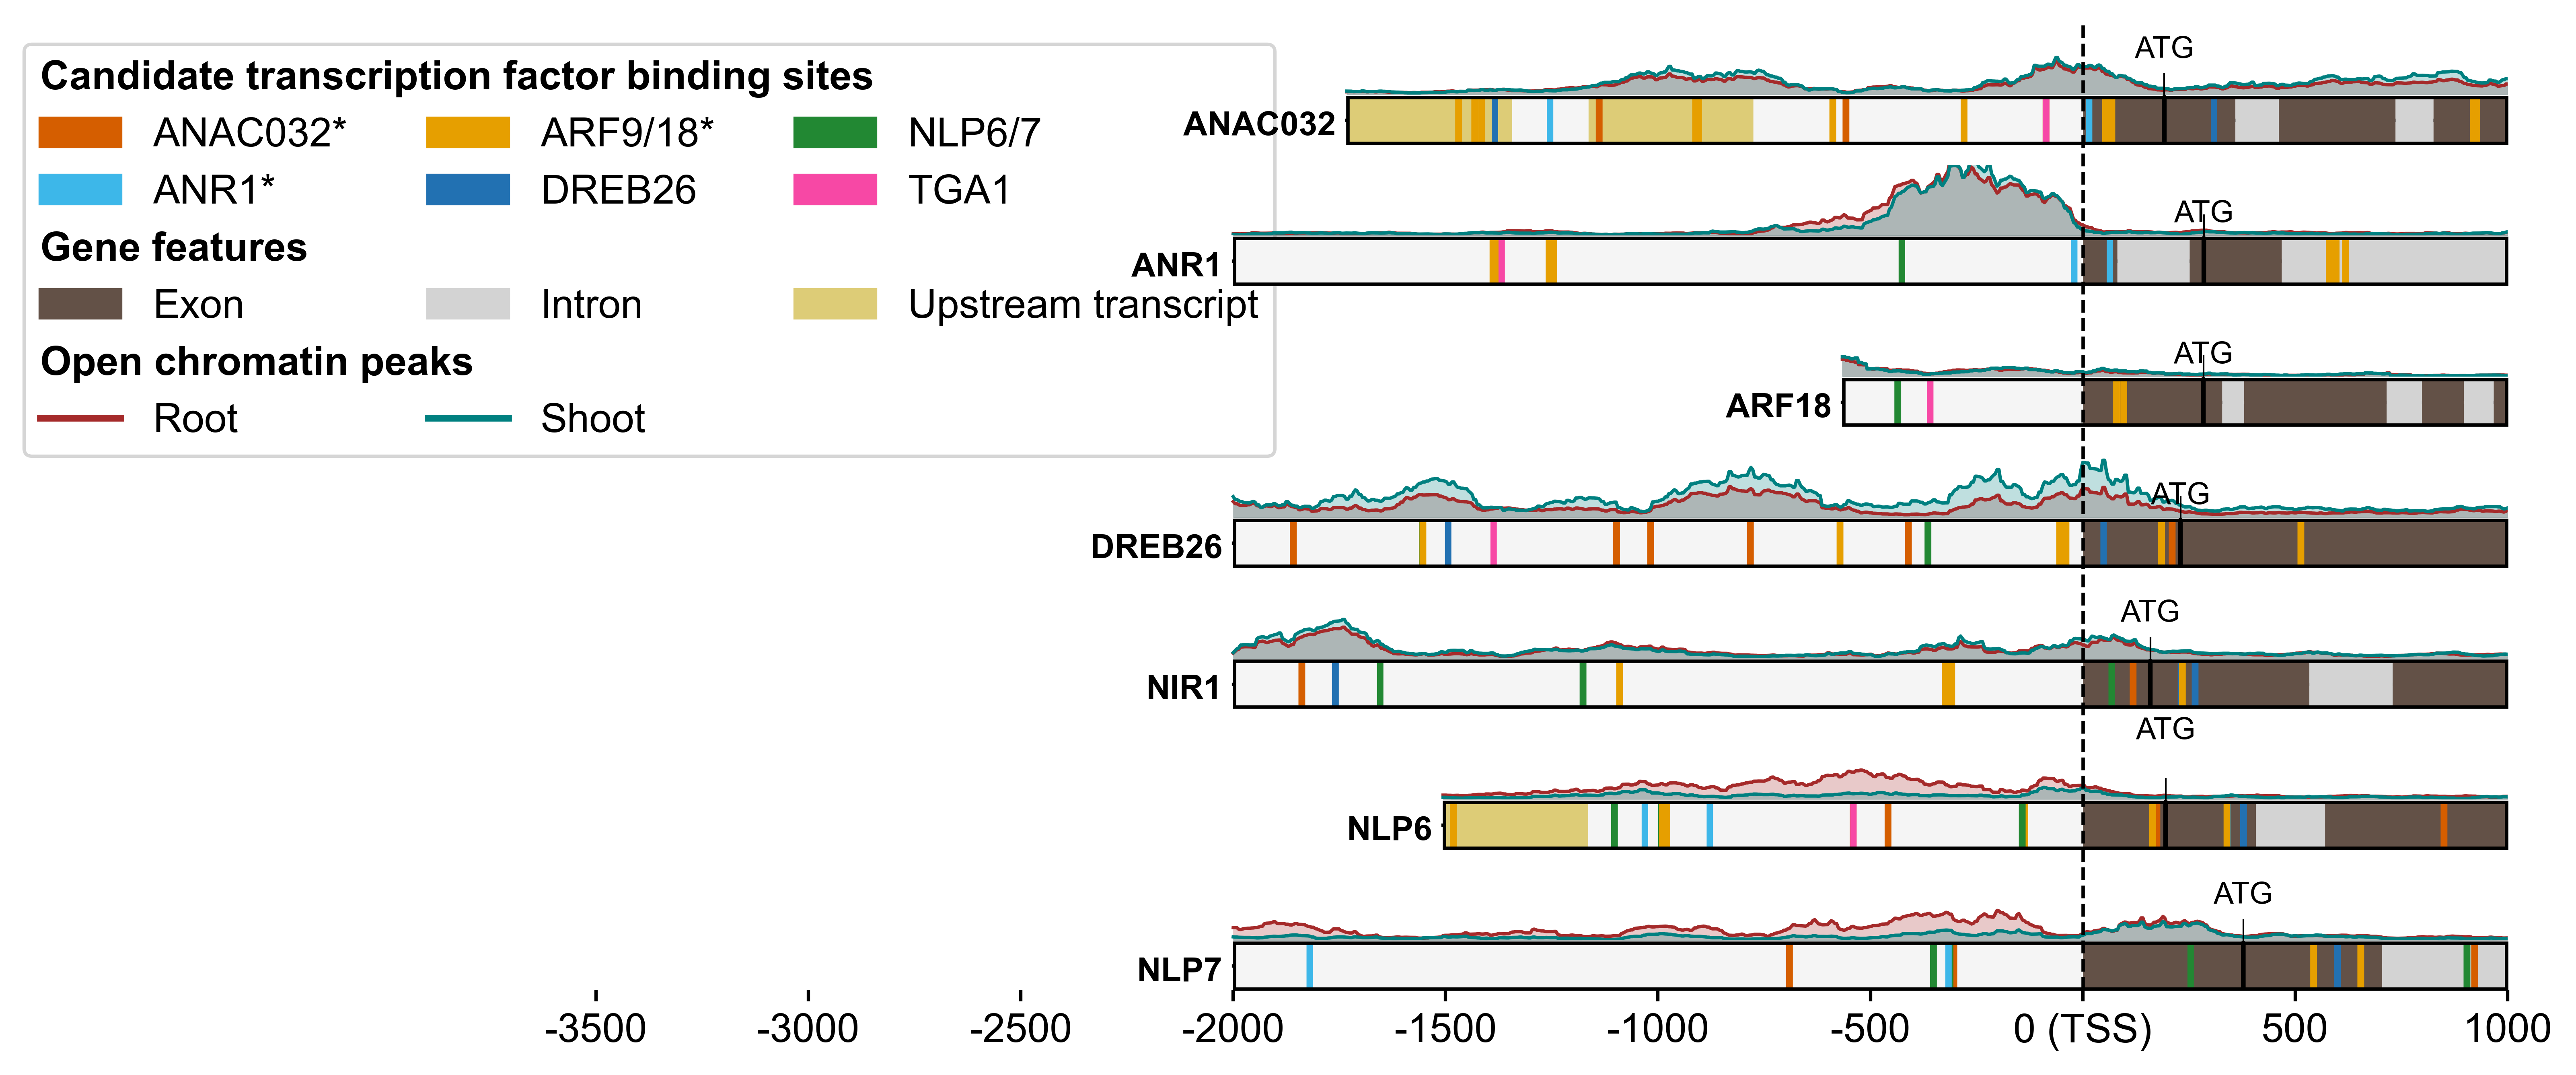

In [22]:
if __name__ == "__main__":
    import sys

    main(sys.argv[1:])